# Visualizing Neural Networks

In [3]:
from notebook.auth import passwd; passwd()

Enter password: ········
Verify password: ········


'sha1:b5fbcbe80efc:d682647ecb51e977d68df52ea6fdeb0e3863a987'

### Setup Environment

In [1]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
import functools

from sklearn.metrics import accuracy_score

import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

### Useful Functions

In [2]:
def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))


### Load Dataset

In [3]:
def pathJoin(*args):
    return os.path.abspath(os.path.join(*args))

class BaseDataset(Dataset):

    def __init__(self, directory, split='train', transforms=None):
        self.datapoints = defaultdict(list)
        self.split = split
        self.directory = pathJoin(directory, split)
        self.datapoints = self.loadDataset()
        self.transforms = transforms

    def __len__(self):
        return len(self.datapoints)

    def __getitem__(self, idx):
        datapoint = self.loadDatapoint(idx)
        return datapoint

    def loadDatapoint(self, idx):
        raise NotImplementedError('Function "loadDatapoint" is not implemented')

    def loadDataset(self, name):
        raise NotImplementedError('Function "loadDataset" is not implemented')

class ImageNetDataset(BaseDataset):

    def __init__(self, directory, split='train', transforms=None):
        super().__init__(directory, split, transforms)
        self.descriptions = self.loadDescriptions()
        self.classes = self.loadClasses()
        self.groundtruths = self.loadValidationGroundtruths() if split == 'val' else []

    def loadDatapoint(self, idx):
        filepath = self.datapoints[idx]
        image = Image.open(filepath).convert('RGB')
        if self.split == 'val':
            groundtruth = self.groundtruths[idx]
        elif self.split == 'train':
            groundtruth = self.classes.index(filepath.split('/').pop().split('_')[0])
        if self.transforms:
            image = self.transforms(image)
        return (filepath, image, groundtruth, self.descriptions[groundtruth])

    def loadDataset(self):
        datapoints = []

        dataset_file_list_filename = 'ilsvrc2012{}.txt'.format(self.split)
        dataset_file_list_path = os.path.join(self.directory, dataset_file_list_filename)

        with open(dataset_file_list_path, 'r') as dataset_file_list_file:
            for line in tqdm(dataset_file_list_file, total=sum(1 for line in open(dataset_file_list_path))):
                file_path = pathJoin(self.directory, self.sanitizeFilename(line))
                datapoints.append(file_path)
        
        return datapoints
    
    def sanitizeFilename(self, filename):
        return filename.replace('"', '').strip()

    def loadDescriptions(self):
        descriptions = []

        descriptions_filename = 'synsets_with_descriptions.txt'
        descriptions_path = pathJoin(self.directory, '..', descriptions_filename)

        with open(descriptions_path, 'r') as descriptions_file:
            for line in descriptions_file:
                description_breakdown = line.split(' ')
                description_breakdown.pop(0)
                description = ' '.join(description_breakdown).strip()
                descriptions.append(description)

        return descriptions

    def loadValidationGroundtruths(self):
        groundtruths = []

        groundtruths_filename = 'validation_ground_truth.txt'
        groundtruths_path = pathJoin(self.directory, '..', groundtruths_filename)

        with open(groundtruths_path, 'r') as groundtruths_file:
            for line in groundtruths_file:
                groundtruth_breakdown = line.split(' ')
                groundtruth_breakdown.pop(0)
                groundtruth = ' '.join(groundtruth_breakdown).strip()
                groundtruths.append(int(groundtruth))

        return groundtruths

    def loadClasses(self):
        classes = []

        classes_filename = 'synsets.txt'
        classes_path = pathJoin(self.directory, '..', classes_filename)

        with open(classes_path, 'r') as classes_file:
            for line in classes_file:
                classes.append(line.strip())

        return classes


class DeNormalize(object):
    # Source: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


BATCH_SIZE = 64

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
denormalize = DeNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

imagenet_dataset_path = os.path.join('datasets', 'imagenet')

# imagenet_train_dataset = ImageNetDataset(imagenet_dataset_path, transforms=test_transforms)
imagenet_val_dataset = ImageNetDataset(imagenet_dataset_path, split='val', transforms=test_transforms)
# imagenet_test_dataset = ImageNetDataset(imagenet_dataset_path, split='test')

# imagenet_train_loader = DataLoader(imagenet_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
imagenet_val_loader = DataLoader(imagenet_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# imagenet_test_loader = DataLoader(imagenet_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 50000/50000 [00:01<00:00, 28921.56it/s]


### Visualize Dataset

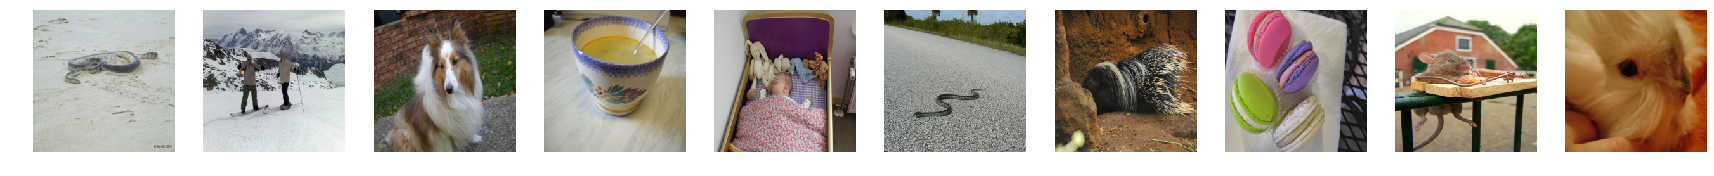

In [4]:
toImage = torchvision.transforms.ToPILImage()

plt.figure(figsize=(30,30))
number_of_images = 10

for index, image in enumerate(imagenet_val_dataset):
    plt.subplot(1, number_of_images, index+1)
    plt.imshow(toImage(denormalize(image[1])))
    plt.axis('off')
    if index == number_of_images-1:
        break

### Load Model

Name: conv1 | Shape: torch.Size([64, 3, 7, 7]) | Count: 64


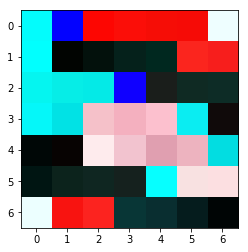

In [11]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.eval();

convolution = {}

# list filters
for name, weights in resnet50.named_parameters():
    if 'conv' in name:
        name = name.split('.')
        name.pop()
        name = '.'.join(name)
        convolution[name] = torch.zeros(weights.shape[1:])
        print('Name: {} | Shape: {} | Count: {}'.format(name, weights.shape, weights.shape[0]))
    plt.figure()
    for filter_index in range(weights.shape[0]):
        image = toImage(weights[filter_index, ...])
        rows = weights.shape[0]/weights.shape[0]
        rows = weights.shape[0]%weights.shape[0]
        plt.subplot()
        plt.imshow(image)
    break


## View Learned Filters

In [154]:
def hooker(name):
    def hook(self, input, output):
        if name in convolution:
            for filter_index in range(output.shape[1]):
                convolution[name][filter_index, ...] = output[0, filter_index]
    return hook

def add_hooks(model, hooker):
    names = {}
    for name, param in model.named_parameters():
        name = name.split('.')
        name.pop()
        name = '.'.join(name)
        names[name] = None

    names = list(names)
    for index, name in enumerate(names):
        module = rgetattr(model, name)
        module.register_forward_hook(hooker(name))

# add hooks to resnet50
add_hooks(resnet50, hooker)

In [155]:
resnet50(image[1].unsqueeze(0));

RuntimeError: The expanded size of the tensor (7) must match the existing size (112) at non-singleton dimension 1.  Target sizes: [7, 7].  Tensor sizes: [112, 112]

In [126]:
for a in convolution:
    print(a, convolution[a][0].shape)
    break

AttributeError: 'list' object has no attribute 'shape'

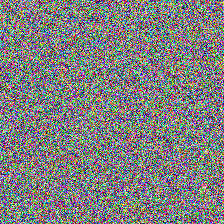

In [118]:
import numpy as np
toImage(torch.from_numpy(np.uint8(np.random.uniform(0, 255, (3, 224, 224)))))

In [165]:
class CNNLayerVisualization():
    # Source: github.com/utkuozbulak
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Generate a random image
        self.created_image = Image.fromarray(np.uint8(np.random.uniform(150, 180, (224, 224, 3))))
        # Create the folder to export images if not exists
        if not os.path.exists('../generated'):
            os.makedirs('../generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]

        # Hook the selected layer
        module = rgetattr(self.model, self.selected_layer)
        module.register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Process image and return variable
        self.processed_image = test_transforms(self.created_image)
        # Define optimizer for the image
        optimizer = Adam([self.processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = self.processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image)
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)

    def visualise_layer_without_hooks(self):
        # Process image and return variable
        self.processed_image = preprocess_image(self.created_image)
        # Define optimizer for the image
        optimizer = Adam([self.processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = self.processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                x = layer(x)
                if index == self.selected_layer:
                    # Only need to forward until the selected layer is reached
                    # Now, x is the output of the selected layer
                    break
            # Here, we get the specific filter from the output of the convolution operation
            # x is a tensor of shape 1x512x28x28.(For layer 17)
            # So there are 512 unique filter outputs
            # Following line selects a filter from 512 filters so self.conv_output will become
            # a tensor of shape 28x28
            self.conv_output = x[0, self.selected_filter]
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image)
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)



In [166]:
cnn_layer = 'conv1'
filter_pos = 5
# Fully connected layer is not needed
pretrained_model = torchvision.models.resnet50(pretrained=True)
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

# Layer visualization without pytorch hooks
# layer_vis.visualise_layer_without_hooks()


TypeError: 'ResNet' object is not iterable

In [170]:
for x in resnet50.parameters():
    print(x.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([512, 128, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 256, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([128, 512, 1, 1])
torch.Size([128])
torch.Siz

In [151]:
x = torch.zeros(5, 3, 3)
y = torch.ones(3, 3)

In [152]:
print(x)
x[2, ...] = y
print(x)

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])
